# **Aspect Based Sentiment Analysis: (3 Classes) - Restaurant - ABSA Dataset**

### Step 1: Install & Import Dependencies

In [36]:
!pip install -q transformers==4.41.2 peft==0.11.1 accelerate==0.31.0 datasets


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.metrics.pairwise import cosine_similarity

import torch
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    Trainer, TrainingArguments, EarlyStoppingCallback
)
from peft import LoraConfig, TaskType, get_peft_model

### Step 2: Mount Google Drive & Load Data

In [38]:
#file_path = "/home/arafatmdeasin/usman/project/dataset/IMDB Dataset (2 Classes).csv"

#df = pd.read_csv(file_path, encoding='ISO-8859-1')
#df = df[['Text', 'Sentiment']].dropna()
#df.head()

from google.colab import drive
drive.mount('/content/drive')

file_path = "/content/drive/MyDrive/Restaurant - ABSA.csv"
df = pd.read_csv(file_path, encoding='ISO-8859-1')
df = df[['Text', 'Sentiment']].dropna()
df.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Text,Sentiment
0,But the staff was so horrible to us.,Negative
1,To be completely fair[comma] the only redeemin...,Positive
2,The food is uniformly exceptional[comma] with ...,Positive
3,The food is uniformly exceptional[comma] with ...,Positive
4,The food is uniformly exceptional[comma] with ...,Neutral


### Step 3: Visualize Dataset Distribution

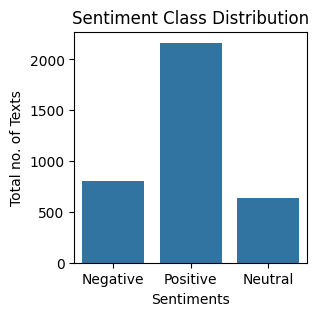

In [39]:
plt.figure(figsize=(3,3))
sns.countplot(data=df, x='Sentiment')
plt.title("Sentiment Class Distribution")
plt.xlabel("Sentiments")
plt.ylabel("Total no. of Texts")
plt.grid(False)
plt.show()

### Step 4: Encode Labels

In [40]:
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['Sentiment'])

print("Label Mapping:")
for i, label in enumerate(label_encoder.classes_):
    print(f"{label}: {i}")

Label Mapping:
Negative: 0
Neutral: 1
Positive: 2


### Step 5: Train-Test Split

In [41]:
train_val_texts, test_texts, train_val_labels, test_labels = train_test_split(
    df['Text'].tolist(),
    df['label'].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=df['label']
)

train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_val_texts,
    train_val_labels,
    test_size=0.2,
    random_state=42,
    stratify=train_val_labels
)

print(f"Train set size: {len(train_texts)}")
print(f"Validation set size: {len(val_texts)}")
print(f"Test set size: {len(test_texts)}")

Train set size: 2304
Validation set size: 577
Test set size: 721


### Step 6: Tokenization

In [42]:
base_model_name = "microsoft/deberta-v3-base"
finetuned_model_name = "yangheng/deberta-v3-base-absa-v1.1"
tokenizer = AutoTokenizer.from_pretrained(base_model_name)

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=512)

/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:560: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


### Step 7: Dataset Class

In [43]:
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()} | {'labels': torch.tensor(self.labels[idx])}

    def __len__(self):
        return len(self.labels)

train_dataset = SentimentDataset(train_encodings, train_labels)
val_dataset = SentimentDataset(val_encodings, val_labels)
test_dataset = SentimentDataset(test_encodings, test_labels)

### Step 9: Define Metrics Function

In [44]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    proba = torch.softmax(torch.tensor(logits), dim=-1).numpy()

    acc = accuracy_score(labels, preds) * 100

    prec, rec, f1, _ = precision_recall_fscore_support(labels, preds, average="macro")

    sims = []
    for i in range(len(labels)):
        true_onehot = np.zeros(proba.shape[1])
        true_onehot[labels[i]] = 1
        sims.append(cosine_similarity([true_onehot], [proba[i]])[0][0])
    similarity_score = np.mean(sims) * 100

    confidence_score = np.mean(np.max(proba, axis=1)) * 100

    return {
        "accuracy": acc,
        "precision": prec * 100,
        "recall": rec * 100,
        "f1": f1 * 100,
        "similarity_score": similarity_score,
        "confidence_score": confidence_score
    }

### Step 10: Evaluate Without Fine-Tuning

In [45]:
baseline_model = AutoModelForSequenceClassification.from_pretrained(finetuned_model_name)

baseline_trainer = Trainer(
    model=baseline_model,
    args=TrainingArguments(
        output_dir="./results",
        per_device_eval_batch_size=32
    ),
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

baseline_metrics = baseline_trainer.evaluate()

print("\n===== Performance of Pretrained Transformer Model =====\n")

metrics_to_show = [
    "accuracy",
    "precision",
    "recall",
    "f1",
    "similarity_score",
    "confidence_score"
]

for metric in metrics_to_show:
    key = f"eval_{metric}"
    if key in baseline_metrics:
        print(f"{metric.replace('_', ' ').title()}: {baseline_metrics[key]:.2f}%")

print("\n===== Evaluation Details =====")
print(f"Eval Loss: {baseline_metrics.get('eval_loss', 0.0):.4f}")
print(f"Runtime: {baseline_metrics.get('eval_runtime', 0.0):.2f} sec")
print(f"Samples per second: {baseline_metrics.get('eval_samples_per_second', 0.0):.2f}")

/usr/local/lib/python3.12/dist-packages/accelerate/accelerator.py:477: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)



===== Performance of Pretrained Transformer Model =====

Accuracy: 73.09%
Precision: 67.40%
Recall: 70.78%
F1: 68.35%
Similarity Score: 77.84%
Confidence Score: 75.92%

===== Evaluation Details =====
Eval Loss: 0.6593
Runtime: 1.81 sec
Samples per second: 397.27


#### Step 10.1:Confusion Matrix (Without Fine-Tuning)

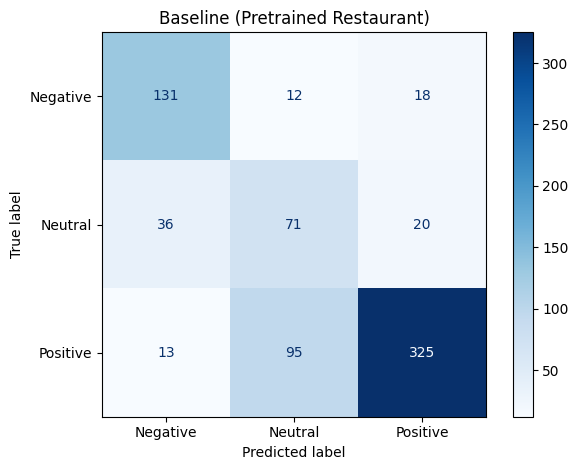

In [47]:
preds = baseline_trainer.predict(test_dataset)
y_true = preds.label_ids
y_pred = preds.predictions.argmax(-1)

cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm, display_labels=label_encoder.classes_).plot(cmap="Blues")
plt.title("Baseline (Pretrained Restaurant)")
plt.tight_layout()
plt.show()

### Step 11: Load the Base Model

In [48]:
model_base = AutoModelForSequenceClassification.from_pretrained(
    base_model_name,
    num_labels=len(label_encoder.classes_),
    hidden_dropout_prob=0.2,
    attention_probs_dropout_prob=0.2
)

training_args = TrainingArguments(
    output_dir="./results-base-improved",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    weight_decay=0.1,
    logging_dir="./logs",
    logging_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    fp16=True,
    report_to="none",
    seed=42,
    warmup_ratio=0.1,
    lr_scheduler_type="cosine",
    gradient_accumulation_steps=2,
    max_grad_norm=1.0
)

trainer_base = Trainer(
    model=model_base,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

trainer_base.train()

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/accelerate/accelerator.py:477: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Similarity Score,Confidence Score
1,0.941000,0.707609,60.138648,20.046216,33.333333,25.036075,75.222388,68.664185
2,0.709500,0.627732,72.963605,45.816190,58.623566,50.696242,78.773689,73.043274
3,0.593300,0.586761,76.083189,67.832951,60.729914,54.783890,80.975315,80.260216
4,0.531500,0.589916,76.949740,70.689257,62.848022,58.935945,81.225158,81.560593
5,0.509100,0.586603,76.083189,61.794173,62.081174,56.690313,81.071150,80.930717


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TrainOutput(global_step=720, training_loss=0.6568854120042589, metrics={'train_runtime': 349.9219, 'train_samples_per_second': 32.922, 'train_steps_per_second': 2.058, 'total_flos': 538734384115200.0, 'train_loss': 0.6568854120042589, 'epoch': 5.0})

In [49]:
finetuned_metrics = trainer_base.evaluate(test_dataset)

print("\n" + "=" * 5 + " Performance after Fine-Tuning Base Model " + "=" * 5 + "\n")

metrics_to_show = [
    "accuracy",
    "precision",
    "recall",
    "f1",
    "similarity_score",
    "confidence_score"
]

for metric in metrics_to_show:
    key = f"eval_{metric}"
    if key in finetuned_metrics:
        print(f"{metric.replace('_', ' ').title()}: {finetuned_metrics[key]:.2f}%")

print("\n===== Evaluation Details =====")
print(f"Eval Loss: {finetuned_metrics.get('eval_loss', 0.0):.4f}")
print(f"Runtime: {finetuned_metrics.get('eval_runtime', 0.0):.4f} sec")
print(f"Samples per second: {finetuned_metrics.get('eval_samples_per_second', 0.0):.3f}")


===== Performance after Fine-Tuning Base Model =====

Accuracy: 74.62%
Precision: 65.90%
Recall: 60.42%
F1: 56.71%
Similarity Score: 79.18%
Confidence Score: 81.11%

===== Evaluation Details =====
Eval Loss: 0.6438
Runtime: 1.8586 sec
Samples per second: 387.920


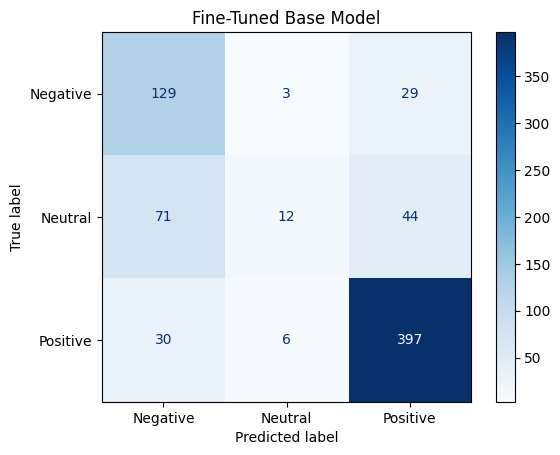

In [50]:
preds = trainer_base.predict(test_dataset)
y_true = preds.label_ids
y_pred = preds.predictions.argmax(-1)
cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm, display_labels=label_encoder.classes_).plot(cmap="Blues")
plt.title("Fine-Tuned Base Model")
plt.show()


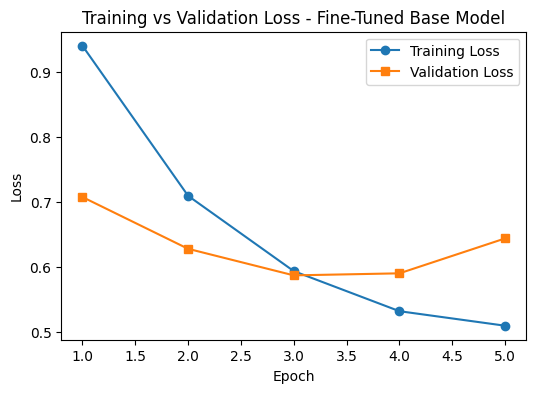

In [51]:
import matplotlib.pyplot as plt

logs_base = trainer_base.state.log_history

train_loss_base = {}
eval_loss_base = {}

for log in logs_base:
    if "loss" in log and "epoch" in log:
        train_loss_base[float(log["epoch"])] = log["loss"]
    if "eval_loss" in log and "epoch" in log:
        eval_loss_base[float(log["epoch"])] = log["eval_loss"]

epochs_base = sorted(set(train_loss_base.keys()) | set(eval_loss_base.keys()))
train_vals_base = [train_loss_base.get(e, None) for e in epochs_base]
eval_vals_base = [eval_loss_base.get(e, None) for e in epochs_base]

# Plot
plt.figure(figsize=(6,4))
plt.plot(epochs_base, train_vals_base, label="Training Loss", marker="o")
plt.plot(epochs_base, eval_vals_base, label="Validation Loss", marker="s")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss - Fine-Tuned Base Model")
plt.legend()
plt.grid(False)
plt.show()


In [52]:
adapter_model = AutoModelForSequenceClassification.from_pretrained(
    base_model_name,
    num_labels=len(label_encoder.classes_),
    hidden_dropout_prob=0.2,
    attention_probs_dropout_prob=0.2
)

peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=16,
    lora_alpha=32,
    lora_dropout=0.2,
    target_modules=["query", "key", "value", "dense", "dense_h_to_4h", "dense_4h_to_h"],
    bias="none",
    inference_mode=False
)

adapter_model = get_peft_model(adapter_model, peft_config)
adapter_model.print_trainable_parameters()

adapter_args = TrainingArguments(
    output_dir="./results-adapter-improved",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-4,
    lr_scheduler_type="cosine",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=2,
    num_train_epochs=12,
    weight_decay=0.05,
    warmup_ratio=0.1,
    logging_dir="./logs-adapter",
    logging_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    save_total_limit=2,
    fp16=True,
    report_to="none",
    seed=42,
    max_grad_norm=1.0,
    dataloader_pin_memory=False
)

trainer_adapter = Trainer(
    model=adapter_model,
    args=adapter_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# Train the model
trainer_adapter.train()



Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1,796,355 || all params: 186,220,806 || trainable%: 0.9646


/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/accelerate/accelerator.py:477: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Similarity Score,Confidence Score
1,1.008400,0.865575,60.138648,20.046216,33.333333,25.036075,69.184824,65.697685
2,0.743100,0.622173,75.909879,47.786398,60.418947,53.100557,79.262746,73.014908
3,0.634900,0.588748,75.043328,47.257802,58.802285,52.313784,80.439945,81.719147
4,0.565200,0.622225,77.469671,68.845302,66.502509,64.345577,80.677159,80.150993
5,0.544100,0.590015,76.429809,65.357434,63.834833,62.644597,81.463987,80.959717
6,0.516700,0.606582,77.296360,66.883620,65.752472,65.734610,81.818706,85.239723


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:945: Futur

TrainOutput(global_step=864, training_loss=0.6687264177534316, metrics={'train_runtime': 204.7982, 'train_samples_per_second': 135.001, 'train_steps_per_second': 8.438, 'total_flos': 660039976028160.0, 'train_loss': 0.6687264177534316, 'epoch': 6.0})

In [53]:
adapter_metrics = trainer_adapter.evaluate(test_dataset)

print("\n" + "=" * 5 + " Performance with Adapter (LoRA) Fine-Tuning " + "=" * 5 + "\n")

print(f"Accuracy: {adapter_metrics.get('eval_accuracy', 0.0):.2f}%")
print(f"Precision: {adapter_metrics.get('eval_precision', 0.0):.2f}%")
print(f"Recall: {adapter_metrics.get('eval_recall', 0.0):.2f}%")
print(f"F1: {adapter_metrics.get('eval_f1', 0.0):.2f}%")
print(f"Similarity Score: {adapter_metrics.get('eval_similarity_score', 0.0):.2f}%")
print(f"Confidence Score: {adapter_metrics.get('eval_confidence_score', 0.0):.2f}%")

print("\n===== Evaluation Details =====")
print(f"Eval Loss: {adapter_metrics.get('eval_loss', 0.0):.4f}")
print(f"Runtime: {adapter_metrics.get('eval_runtime', 0.0):.4f} sec")
print(f"Samples per second: {adapter_metrics.get('eval_samples_per_second', 0.0):.3f}")


===== Performance with Adapter (LoRA) Fine-Tuning =====

Accuracy: 73.51%
Precision: 79.28%
Recall: 56.98%
F1: 51.24%
Similarity Score: 78.45%
Confidence Score: 81.62%

===== Evaluation Details =====
Eval Loss: 0.6567
Runtime: 3.5697 sec
Samples per second: 201.977


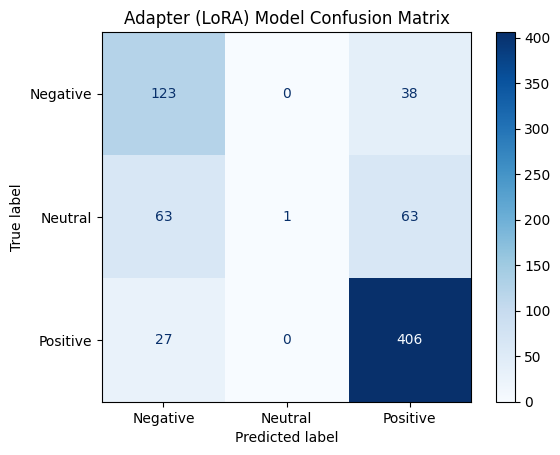

In [54]:

preds = trainer_adapter.predict(test_dataset)
y_true, y_pred = preds.label_ids, preds.predictions.argmax(-1)
cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm, display_labels=label_encoder.classes_).plot(cmap="Blues")
plt.title("Adapter (LoRA) Model Confusion Matrix")
plt.show()

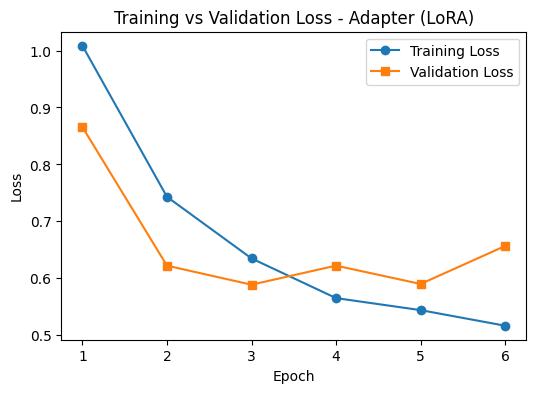

In [55]:
logs_adapter = trainer_adapter.state.log_history

train_loss_adapter = {}
eval_loss_adapter = {}

for log in logs_adapter:
    if "loss" in log and "epoch" in log:
        train_loss_adapter[float(log["epoch"])] = log["loss"]
    if "eval_loss" in log and "epoch" in log:
        eval_loss_adapter[float(log["epoch"])] = log["eval_loss"]

epochs_adapter = sorted(set(train_loss_adapter.keys()) | set(eval_loss_adapter.keys()))
train_vals_adapter = [train_loss_adapter.get(e, None) for e in epochs_adapter]
eval_vals_adapter = [eval_loss_adapter.get(e, None) for e in epochs_adapter]

# Plot
plt.figure(figsize=(6,4))
plt.plot(epochs_adapter, train_vals_adapter, label="Training Loss", marker="o")
plt.plot(epochs_adapter, eval_vals_adapter, label="Validation Loss", marker="s")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss - Adapter (LoRA)")
plt.legend()
plt.grid(False)
plt.show()


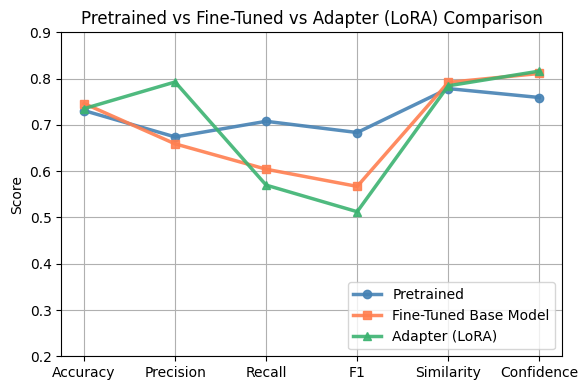

In [57]:
import numpy as np
import matplotlib.pyplot as plt

metrics = ["Accuracy", "Precision", "Recall", "F1", "Similarity", "Confidence"]

# Fixed metric keys - using lowercase and underscores
pretrained_vals = np.array([baseline_metrics[f"eval_{m.lower().replace(' ', '_')}"] for m in ["accuracy", "precision", "recall", "f1", "similarity_score", "confidence_score"]]) / 100
base_vals = np.array([finetuned_metrics[f"eval_{m.lower().replace(' ', '_')}"] for m in ["accuracy", "precision", "recall", "f1", "similarity_score", "confidence_score"]]) / 100
adapter_vals = np.array([adapter_metrics[f"eval_{m.lower().replace(' ', '_')}"] for m in ["accuracy", "precision", "recall", "f1", "similarity_score", "confidence_score"]]) / 100

x = np.arange(len(metrics))

plt.figure(figsize=(6, 4))

plt.plot(x, pretrained_vals, marker='o', linestyle='-', linewidth=2.5, alpha=0.9, label="Pretrained", color='steelblue')
plt.plot(x, base_vals, marker='s', linestyle='-', linewidth=2.5, alpha=0.9, label="Fine-Tuned Base Model", color='coral')
plt.plot(x, adapter_vals, marker='^', linestyle='-', linewidth=2.5, alpha=0.9, label="Adapter (LoRA)", color='mediumseagreen')

plt.xticks(x, metrics, fontsize=10)
plt.ylabel("Score")
plt.ylim(0.20, 0.90)
plt.title("Pretrained vs Fine-Tuned vs Adapter (LoRA) Comparison")
plt.grid(True)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()